# Evaluating Dribbling Ability

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
%autoreload
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from ipywidgets import *

In [2]:
#%pip install scikit-learn
#%pip install mplsoccer
#%pip install xgboost
#%pip install shap
%pip install xlsxwriter

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from mplsoccer import Pitch, FontManager, Sbopen
import matplotlib.patheffects as path_effects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import shap
import pickle
import os
from tqdm import tqdm
from pandas.api.types import is_numeric_dtype
from sklearn.cluster import KMeans


warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


# load carry data
We are only interested in those carries for which at some point of the action at least some pressure was given by an opponent.
Thus the carries are reduced here to those carries where the human annotator added "pressure".

Note: Our own pressure metric only measures the pressure at the beginning of the event and is thus different from the human labeled pressure

In [3]:
carries = pd.read_excel("carries.xlsx")
carries["position_group"] = carries["position_name"].apply(lambda x: x.split(" ")[-1])
carries["position_ignoring_side"] = carries["position_name"].str.replace("Right", "Outer").str.replace("Left", "Outer")


In [4]:
carries = carries[carries["Pressure"]==1]

In [5]:
carries.shape

(20717, 53)

In [6]:
carries.head(4)

,Unnamed: 0,match_id,id,period,minute,second,type_name,sub_type_name,player_name,x,...,xT_end,xT_opp,xT_gain,xt_norm,offensive_value,defensive_value,vaep_value,vaep_norm,position_group,position_ignoring_side
2,2,3893787,adb09aca-b17a-4d77-b957-35b6789d9961,1,0,9,Carry,0,Julie Blakstad,46.5,...,0.004605,0.001559,0.001417,0.601083,-0.000203,0.002068,0.001865,0.521274,Midfield,Outer Midfield
3,3,3893787,1eb207fb-663c-4d1e-895c-8bc44a378b89,1,0,25,Carry,0,Indiah-Paige Janita Riley,74.5,...,0.010043,0.000272,0.007122,0.608824,-0.013069,0.000138,-0.012930,0.511178,Midfield,Outer Midfield
4,4,3893787,7ab3b104-69fd-4178-8d58-fbfb7322177d,1,0,28,Carry,0,Jacqueline Anne Hand,96.3,...,0.012488,0.000121,0.004842,0.605731,0.002322,0.000041,0.002363,0.521614,Forward,Outer Center Forward
5,5,3893787,03e7deb1-27ec-4ff8-845f-d2a514bd8da4,1,0,33,Carry,0,Catherine Joan Bott,81.9,...,0.009176,0.000213,-0.000868,0.597982,0.001924,0.000041,0.001965,0.521342,Back,Outer Back


In [7]:
carries.type_name.unique()

array(['Carry', 'Dribble'], dtype=object)

In [8]:
df_playing_time = pd.read_excel("playing_time_per_player_per_match.xlsx")
df_playing_time.rename(columns = {"position": "position_name"}, inplace=True)

In [9]:
df_playing_time.head(3)

,Unnamed: 0,position_name,playing_time_in_seconds,player_id,player_name,playing_time_in_minutes,playing_ratio,match_id
0,0,Right Center Back,4149,4989,Rebekah Ashley Stott,69.15,0.768333,3893787
1,0,Left Center Back,5400,5028,Katie Bowen,90.00,1.000000,3893787
2,0,Right Defensive Midfield,5400,18145,Ria Percival,90.00,1.000000,3893787


# values per match for playing_times

In [10]:
carries["num_carries"] = 1
carries["Outcome_over_Risk"] = carries["Outcome"] - (1-carries["Risk"])
match_vals = carries.groupby(by = ["match_id", 'player_name', "team_name", "position_name"], as_index=False).sum()
match_vals.shape

(2215, 50)

In [11]:
match_vals = match_vals.merge(df_playing_time[["match_id", "player_name", "playing_time_in_minutes", "position_name"]], 
                             on = ["match_id", "player_name", "position_name"], how = "left", validate = "many_to_one")
match_vals.shape

(2215, 51)

In [12]:
match_vals.head(3)

,match_id,player_name,team_name,position_name,Unnamed: 0,period,minute,second,sub_type_name,x,...,xT_opp,xT_gain,xt_norm,offensive_value,defensive_value,vaep_value,vaep_norm,num_carries,Outcome_over_Risk,playing_time_in_minutes
0,3893787,Ada Stolsmo Hegerberg,Norway Women's,Center Forward,3386,16,491,292,0,934.6,...,0.009148,0.035505,6.638936,0.006070,0.001479,0.007549,5.725164,11,3.527868,90.0
1,3893787,Alexandra Riley,New Zealand Women's,Left Back,2482,12,346,312,0,496.7,...,0.012320,0.014466,5.412066,-0.011239,0.000768,-0.010471,4.672866,9,4.068289,90.0
2,3893787,Aurora Watten Mikalsen,Norway Women's,Goalkeeper,777,3,109,52,0,12.6,...,0.552306,0.001979,1.201005,0.000218,-0.002131,-0.001913,1.038697,2,0.933832,90.0


In [13]:
match_vals.to_excel("match_vals.xlsx")

In [14]:
total_vals = match_vals.groupby(by = ['player_name', "team_name", "position_name"], as_index=False).sum()
total_vals["position_group"] = total_vals["position_name"].apply(lambda x: x.split(" ")[-1])
total_vals["position_ignoring_side"] = total_vals["position_name"].str.replace("Right", "Outer").str.replace("Left", "Outer")


In [15]:
for col in ['Pressure_Delta_Norm', "vaep_norm","xt_norm",'Advance_Metric_Norm',"Pressure_Delta", "advance_diff", "xT_gain", "vaep_value", "Risk", "Outcome_over_Risk"]:
    total_vals[col + "_per_90"] = 90*total_vals[col]/total_vals["playing_time_in_minutes"]

In [16]:
total_vals.head(3)

,player_name,team_name,position_name,match_id,Unnamed: 0,period,minute,second,sub_type_name,x,...,Pressure_Delta_Norm_per_90,vaep_norm_per_90,xt_norm_per_90,Advance_Metric_Norm_per_90,Pressure_Delta_per_90,advance_diff_per_90,xT_gain_per_90,vaep_value_per_90,Risk_per_90,Outcome_over_Risk_per_90
0,Abbie Larkin,Republic of Ireland Women's,Left Wing,3893788,4876,8,298,177,0,319.3,...,7.113890,8.693692,10.142902,7.073819,2.839558,88.844909,0.058405,-0.059191,9.277932,9.277932
1,Abbie Larkin,Republic of Ireland Women's,Right Wing,11681419,76464,10,366,162,0,279.8,...,3.984096,5.316681,6.174085,4.487824,-5.411520,74.065626,0.051170,0.027195,5.851192,5.851192
2,Abbie Larkin,Republic of Ireland Women's,Right Wing Back,3893788,2587,4,181,64,0,127.0,...,26.644845,33.596852,38.838748,32.323937,1.722722,892.497434,0.404744,0.536410,35.951956,35.951956


# Carries: risk vs. value <a class='anchor' id='results'></a>
In this final section, risk and value of carries are compared, and by filtering for positions and players, we are aiming for an identification of patterns in playing style with respect to carries.


### Positions <a class='anchor' id='results1'></a>
Analyzing risk and value of carries per position.

In [17]:
position_aggregation_column = "position_ignoring_side"

In [18]:
total_vals.shape

(1179, 63)

In [19]:
total_vals[position_aggregation_column].value_counts()

Outer Wing                   175
Outer Defensive Midfield     159
Outer Center Back            130
Outer Back                   110
Outer Center Midfield        107
Outer Midfield               101
Outer Center Forward          83
Center Forward                80
Center Attacking Midfield     63
Outer Wing Back               60
Goalkeeper                    37
Center Defensive Midfield     37
Center Back                   19
Outer Attacking Midfield      18
Name: position_ignoring_side, dtype: int64

In [20]:
positions = total_vals.groupby(by = [position_aggregation_column], as_index=False).sum()
positions.head(3)

,position_ignoring_side,match_id,Unnamed: 0,period,minute,second,sub_type_name,x,y,end_x,...,Pressure_Delta_Norm_per_90,vaep_norm_per_90,xt_norm_per_90,Advance_Metric_Norm_per_90,Pressure_Delta_per_90,advance_diff_per_90,xT_gain_per_90,vaep_value_per_90,Risk_per_90,Outcome_over_Risk_per_90
0,Center Attacking Midfield,413028182,38226693,2117,64583,41206,0,100103.1,57095.9,91057.6,...,660.037284,827.221097,953.725676,587.269809,2.165842,60.932328,1.857339,2.46933,922.967827,452.921318
1,Center Back,132483304,2656750,146,4518,3283,0,3480.0,4195.6,3629.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Center Defensive Midfield,261022124,14331749,990,31251,18518,0,38843.1,25101.5,37351.9,...,295.420854,368.184276,425.077330,263.677768,46.691802,305.376405,1.764583,1.97053,393.327742,334.974636


In [21]:
for col in ['Pressure_Delta_Norm', "vaep_norm","xt_norm",'Advance_Metric_Norm', "Risk", "Outcome_over_Risk"]:
    positions[col + "_per_90"] = 90*positions[col]/positions["playing_time_in_minutes"]

In [22]:
counts = total_vals[position_aggregation_column].value_counts()
counts.name = "count"

In [23]:
positions = positions.merge(counts, left_on = position_aggregation_column, right_index=True,
                           validate="one_to_one")
positions.head(3)

,position_ignoring_side,match_id,Unnamed: 0,period,minute,second,sub_type_name,x,y,end_x,...,vaep_norm_per_90,xt_norm_per_90,Advance_Metric_Norm_per_90,Pressure_Delta_per_90,advance_diff_per_90,xT_gain_per_90,vaep_value_per_90,Risk_per_90,Outcome_over_Risk_per_90,count
0,Center Attacking Midfield,413028182,38226693,2117,64583,41206,0,100103.1,57095.9,91057.6,...,13.283224,15.344682,9.617362,2.165842,60.932328,1.857339,2.46933,14.725484,9.275186,63
1,Center Back,132483304,2656750,146,4518,3283,0,3480.0,4195.6,3629.2,...,2.236678,2.577263,1.696583,NaN,NaN,NaN,NaN,2.305682,2.135737,19
2,Center Defensive Midfield,261022124,14331749,990,31251,18518,0,38843.1,25101.5,37351.9,...,8.535431,9.869579,6.201622,46.691802,305.376405,1.764583,1.97053,9.191197,7.458737,37


In [24]:
positions.shape

(14, 60)

In [25]:
positions.to_excel("values_per_positions.xlsx")

### Group similar positions into larger clusters (e.g., Defense, Midfield, Attack)

In [26]:
available_norms = ['Pressure_Delta_Norm', "vaep_norm","xt_norm",'Advance_Metric_Norm', "Outcome_over_Risk_Norm"]

In [27]:
positions.head(3)

,position_ignoring_side,match_id,Unnamed: 0,period,minute,second,sub_type_name,x,y,end_x,...,vaep_norm_per_90,xt_norm_per_90,Advance_Metric_Norm_per_90,Pressure_Delta_per_90,advance_diff_per_90,xT_gain_per_90,vaep_value_per_90,Risk_per_90,Outcome_over_Risk_per_90,count
0,Center Attacking Midfield,413028182,38226693,2117,64583,41206,0,100103.1,57095.9,91057.6,...,13.283224,15.344682,9.617362,2.165842,60.932328,1.857339,2.46933,14.725484,9.275186,63
1,Center Back,132483304,2656750,146,4518,3283,0,3480.0,4195.6,3629.2,...,2.236678,2.577263,1.696583,NaN,NaN,NaN,NaN,2.305682,2.135737,19
2,Center Defensive Midfield,261022124,14331749,990,31251,18518,0,38843.1,25101.5,37351.9,...,8.535431,9.869579,6.201622,46.691802,305.376405,1.764583,1.97053,9.191197,7.458737,37


In [28]:
def scatterplot_with_groupby(df_temp, x_col, y_col, groupby_col, size_col):
    fontsize = 16
    fig, ax = plt.subplots(figsize=(24,9))
    plt.scatter(df_temp[x_col], df_temp[target],  alpha = 1.0, s=df_temp[size_col] * 20)
    for i, txt in enumerate(df_temp[groupby_col]):
        plt.annotate(txt, (df_temp[x_col][i], df_temp[y_col][i]))
    plt.xlabel(x_col, fontsize=fontsize)
    plt.ylabel(y_col, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(True)
    plt.tight_layout()
    plt.title(f'{target} vs. {x_col} per player - Women\'s World Cup 2023') 
    ax.grid(True)

    fig.show()
    
def scatterplot(df_temp, x_col, y_col, color_col):
    fontsize = 16
    fig, ax = plt.subplots(figsize=(24,9))
    plt.scatter(df_temp[x_col], df_temp[target],  alpha = 1.0, c = df_temp[color_col])
    #for i, txt in enumerate(df_temp[groupby_col]):
    #    plt.annotate(txt, (df_temp[x_col][i], df_temp[y_col][i]))
    plt.xlabel(x_col, fontsize=fontsize)
    plt.ylabel(y_col, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(True)
    plt.tight_layout()
    plt.title(f'{target} vs. {x_col} per player - Women\'s European Championship 2021') 
    ax.grid(True)

    
    import matplotlib.patches as mpatches
    import matplotlib.colors as mcolors
    all_colors = mcolors.BASE_COLORS
    color_dict = {vale: all_colors[i] for i, value in enumerate(df_temp[y_col].unique())}
    plotted_colors = df_temp[y_col].map(color_dict)
    fake_handles = [mpatches.Patch(color=item) for item in mydict.values()]
    label = mydict.keys()
    plt.legend(fake_handles, label, loc='upper right', prop={'size': 10})
    
    fig.show()

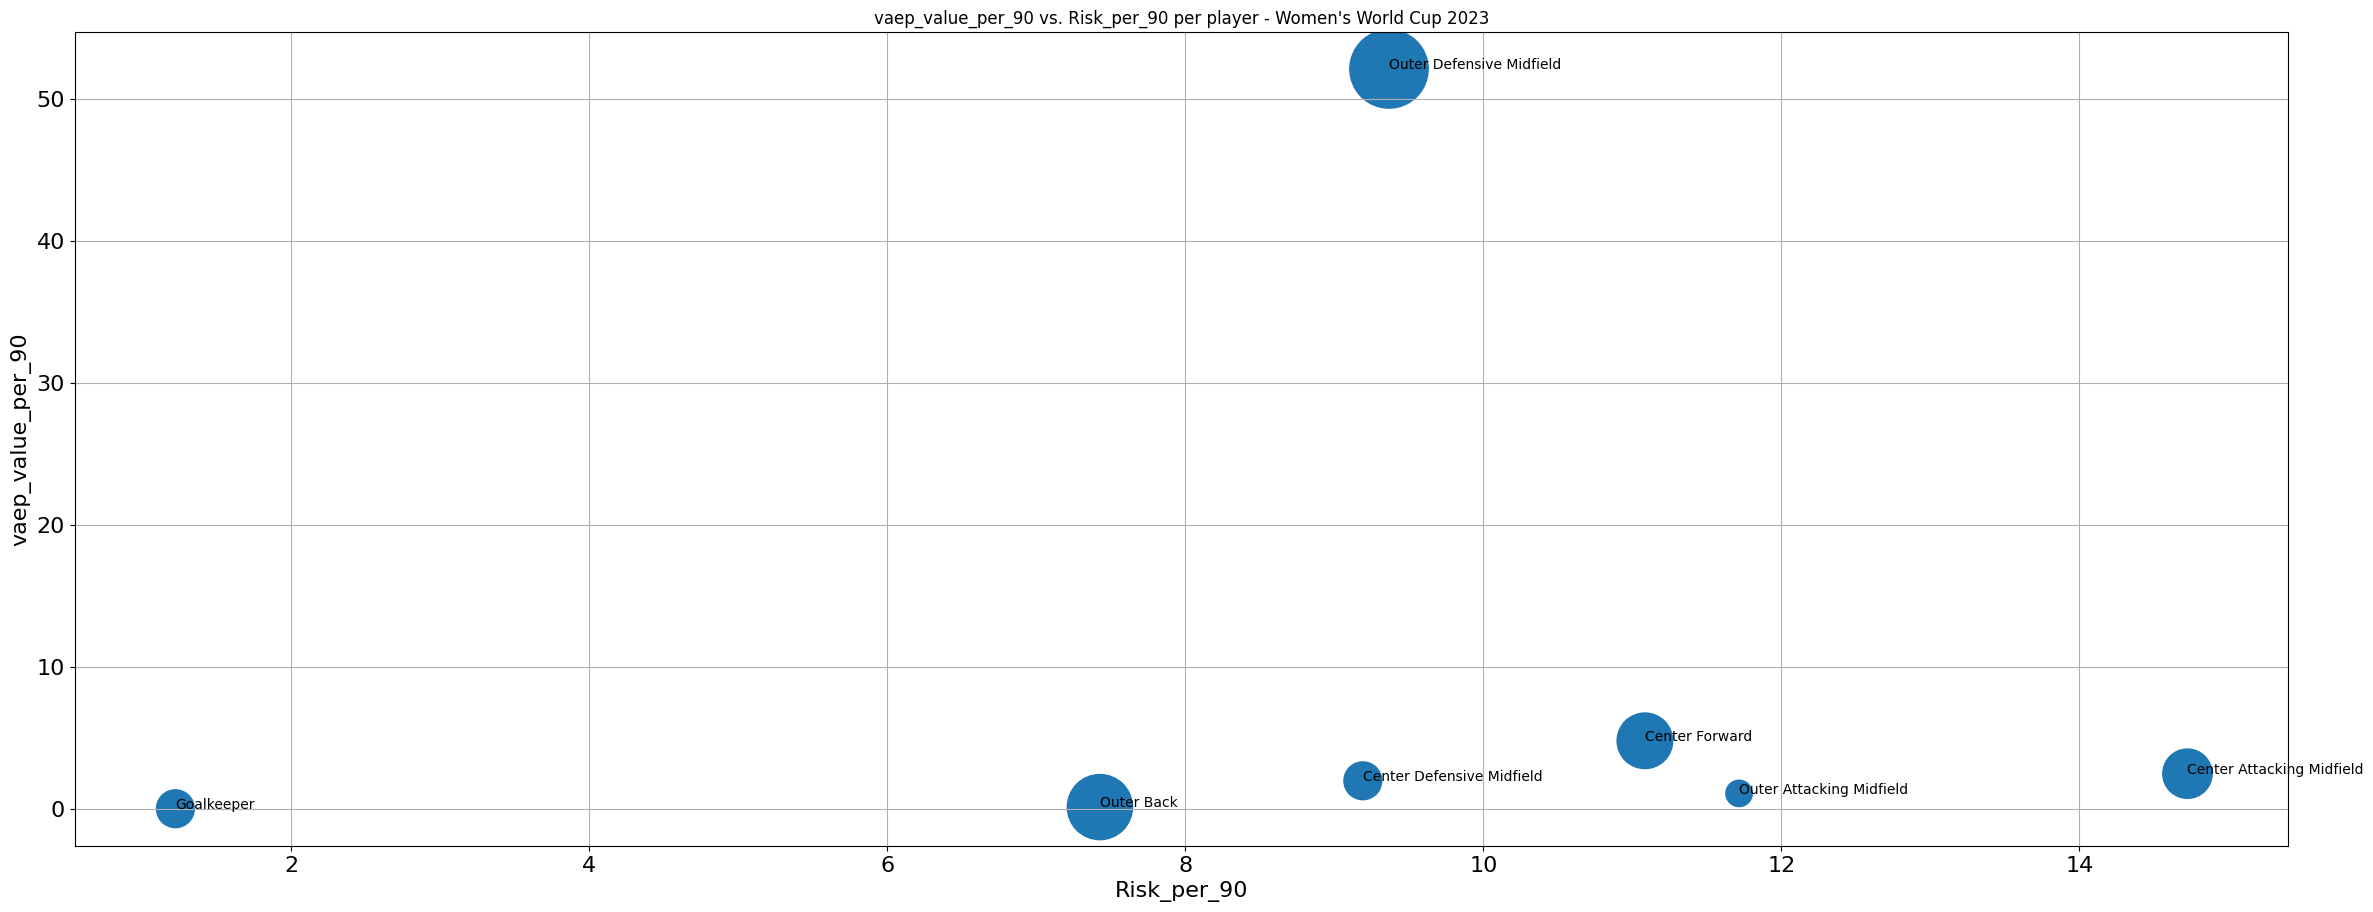

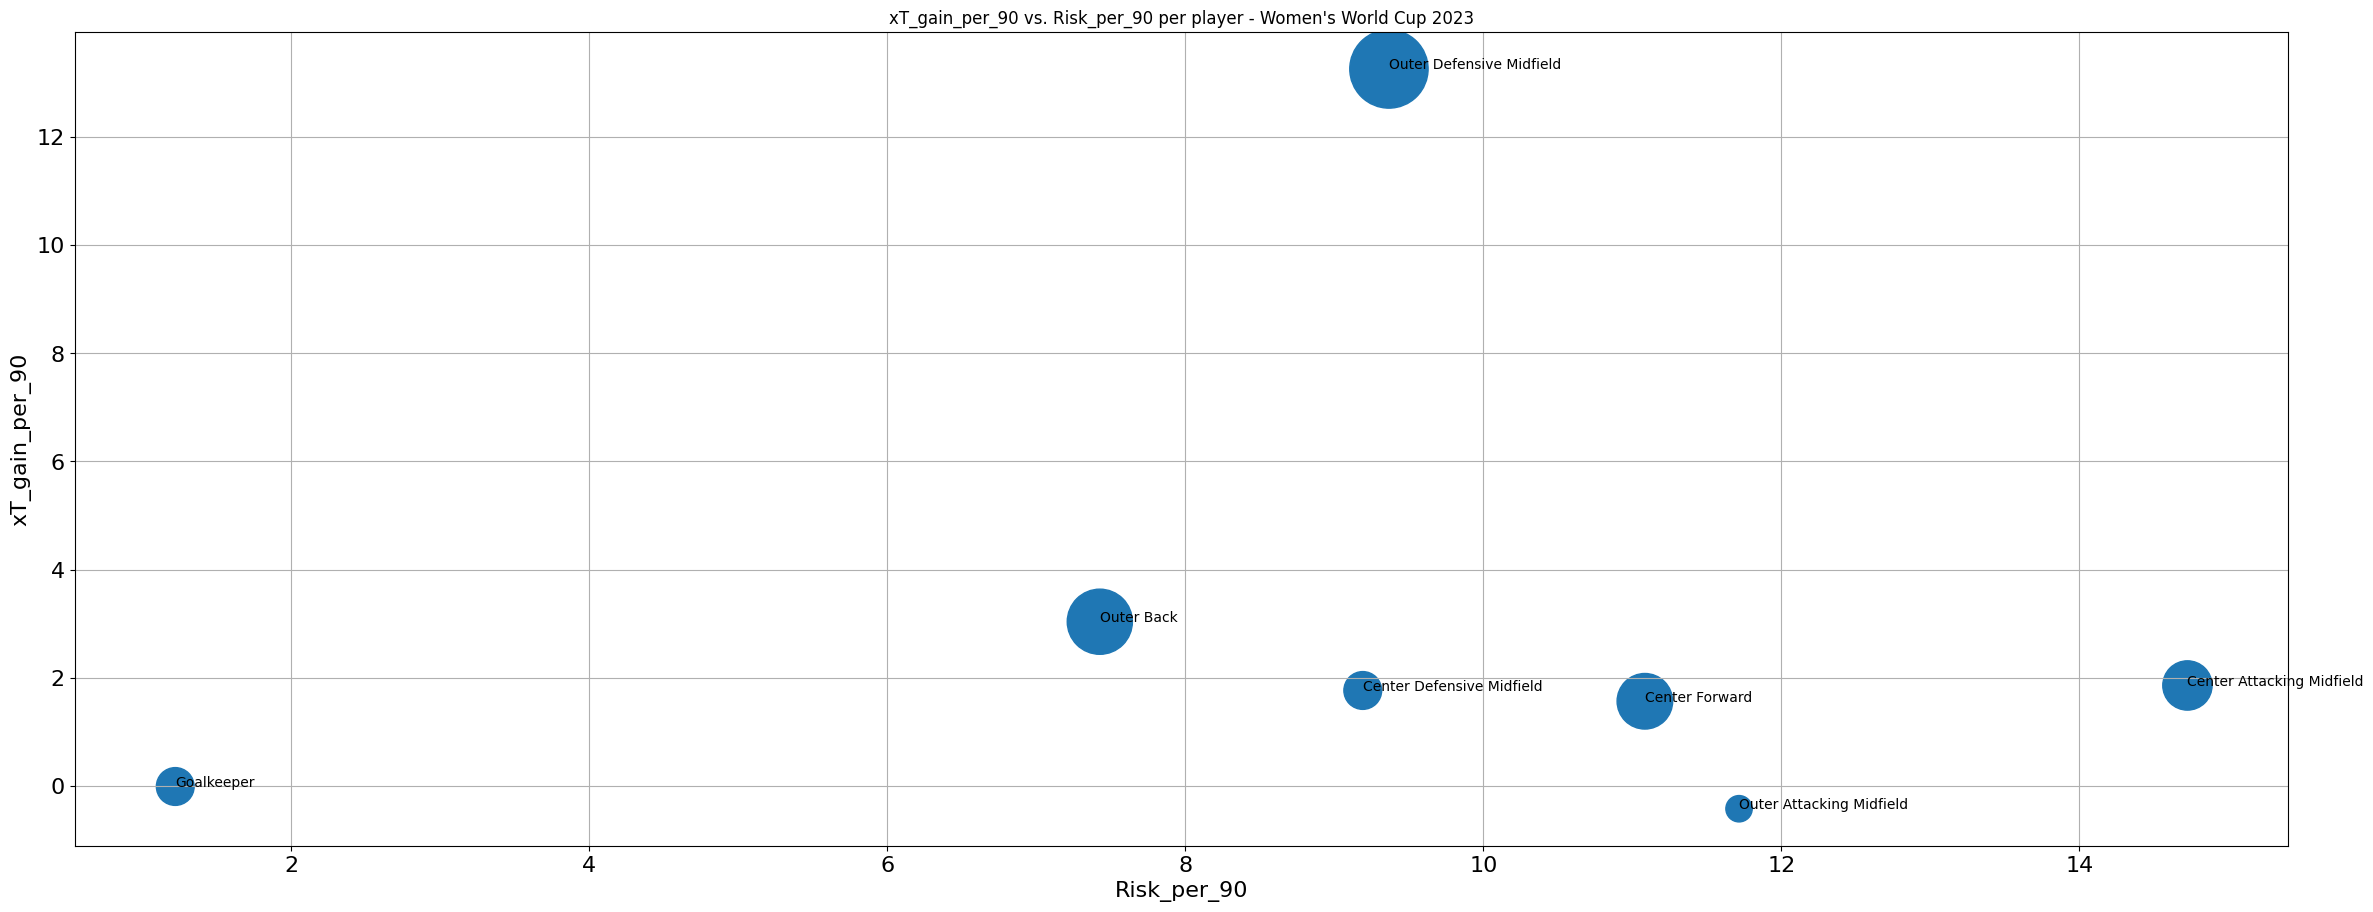

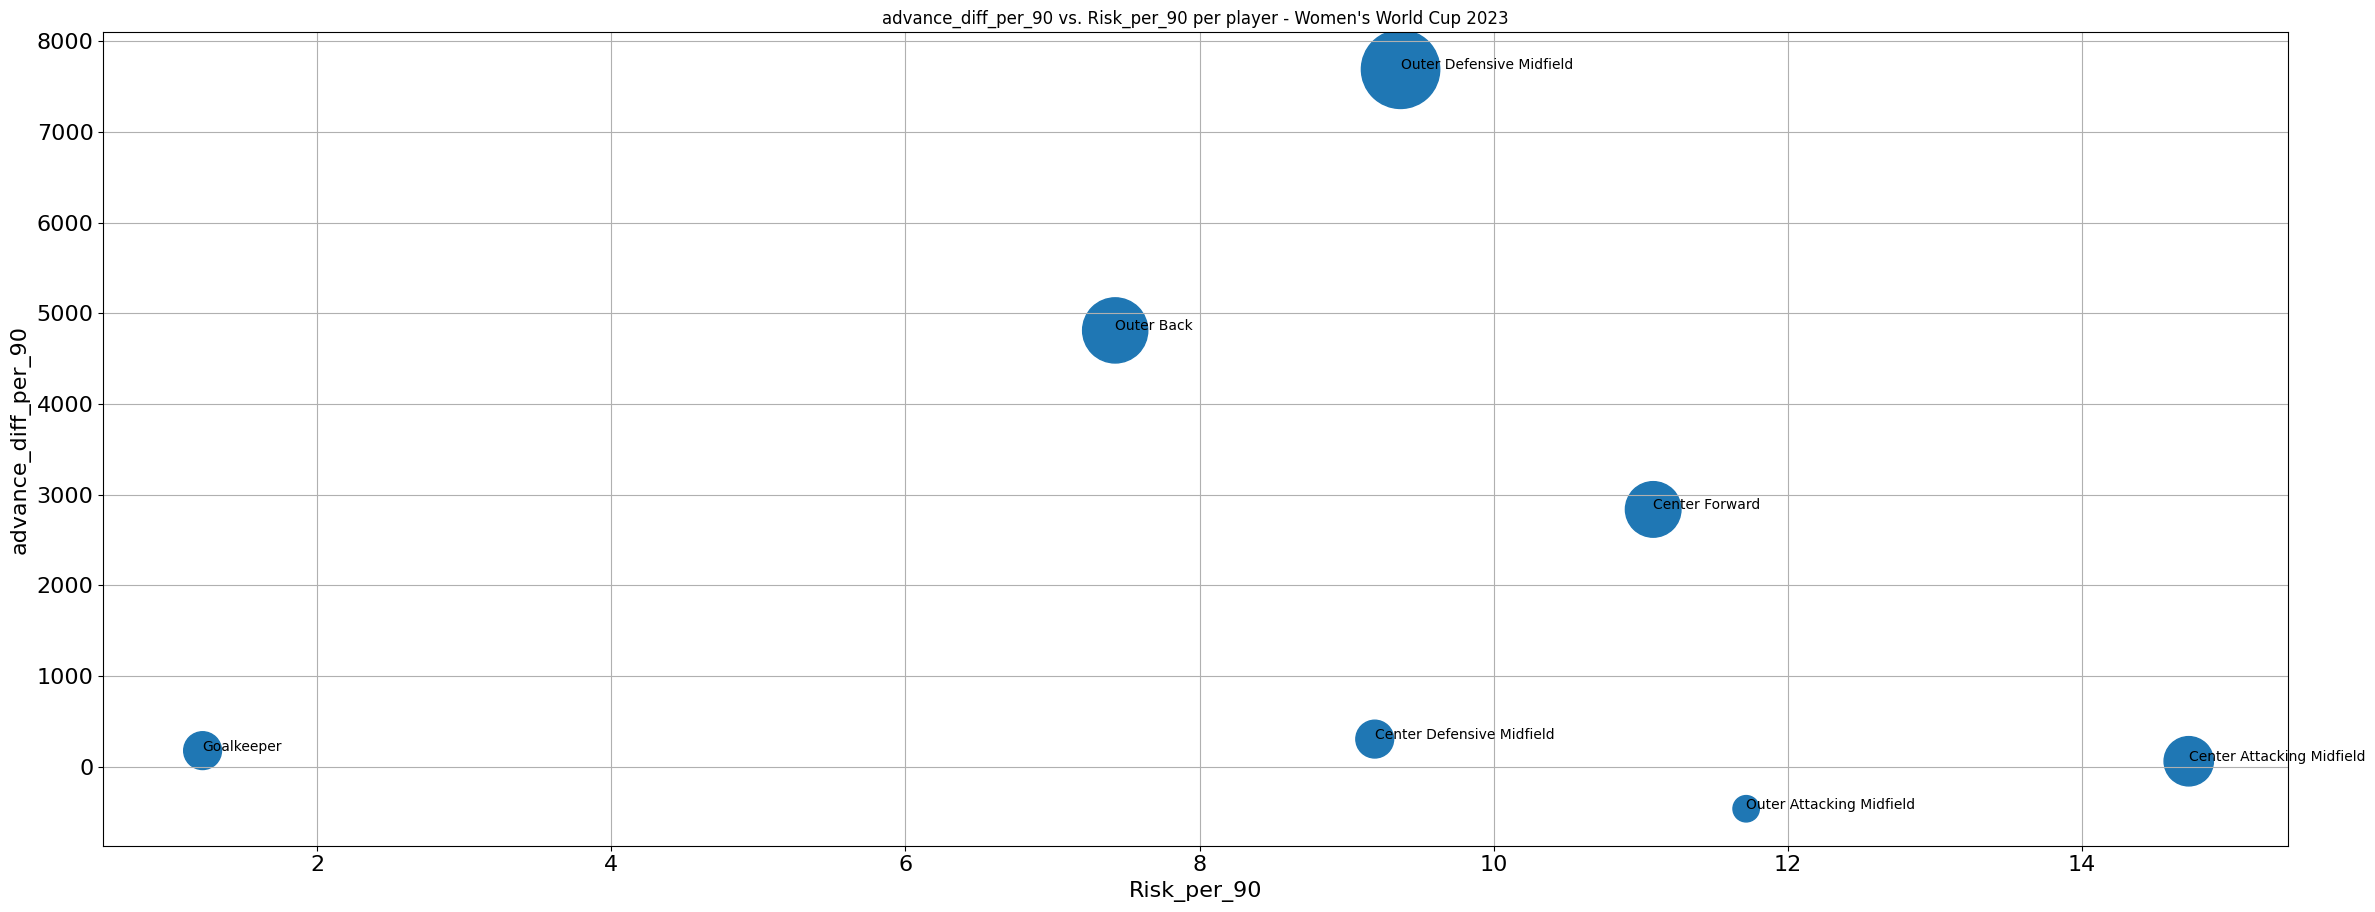

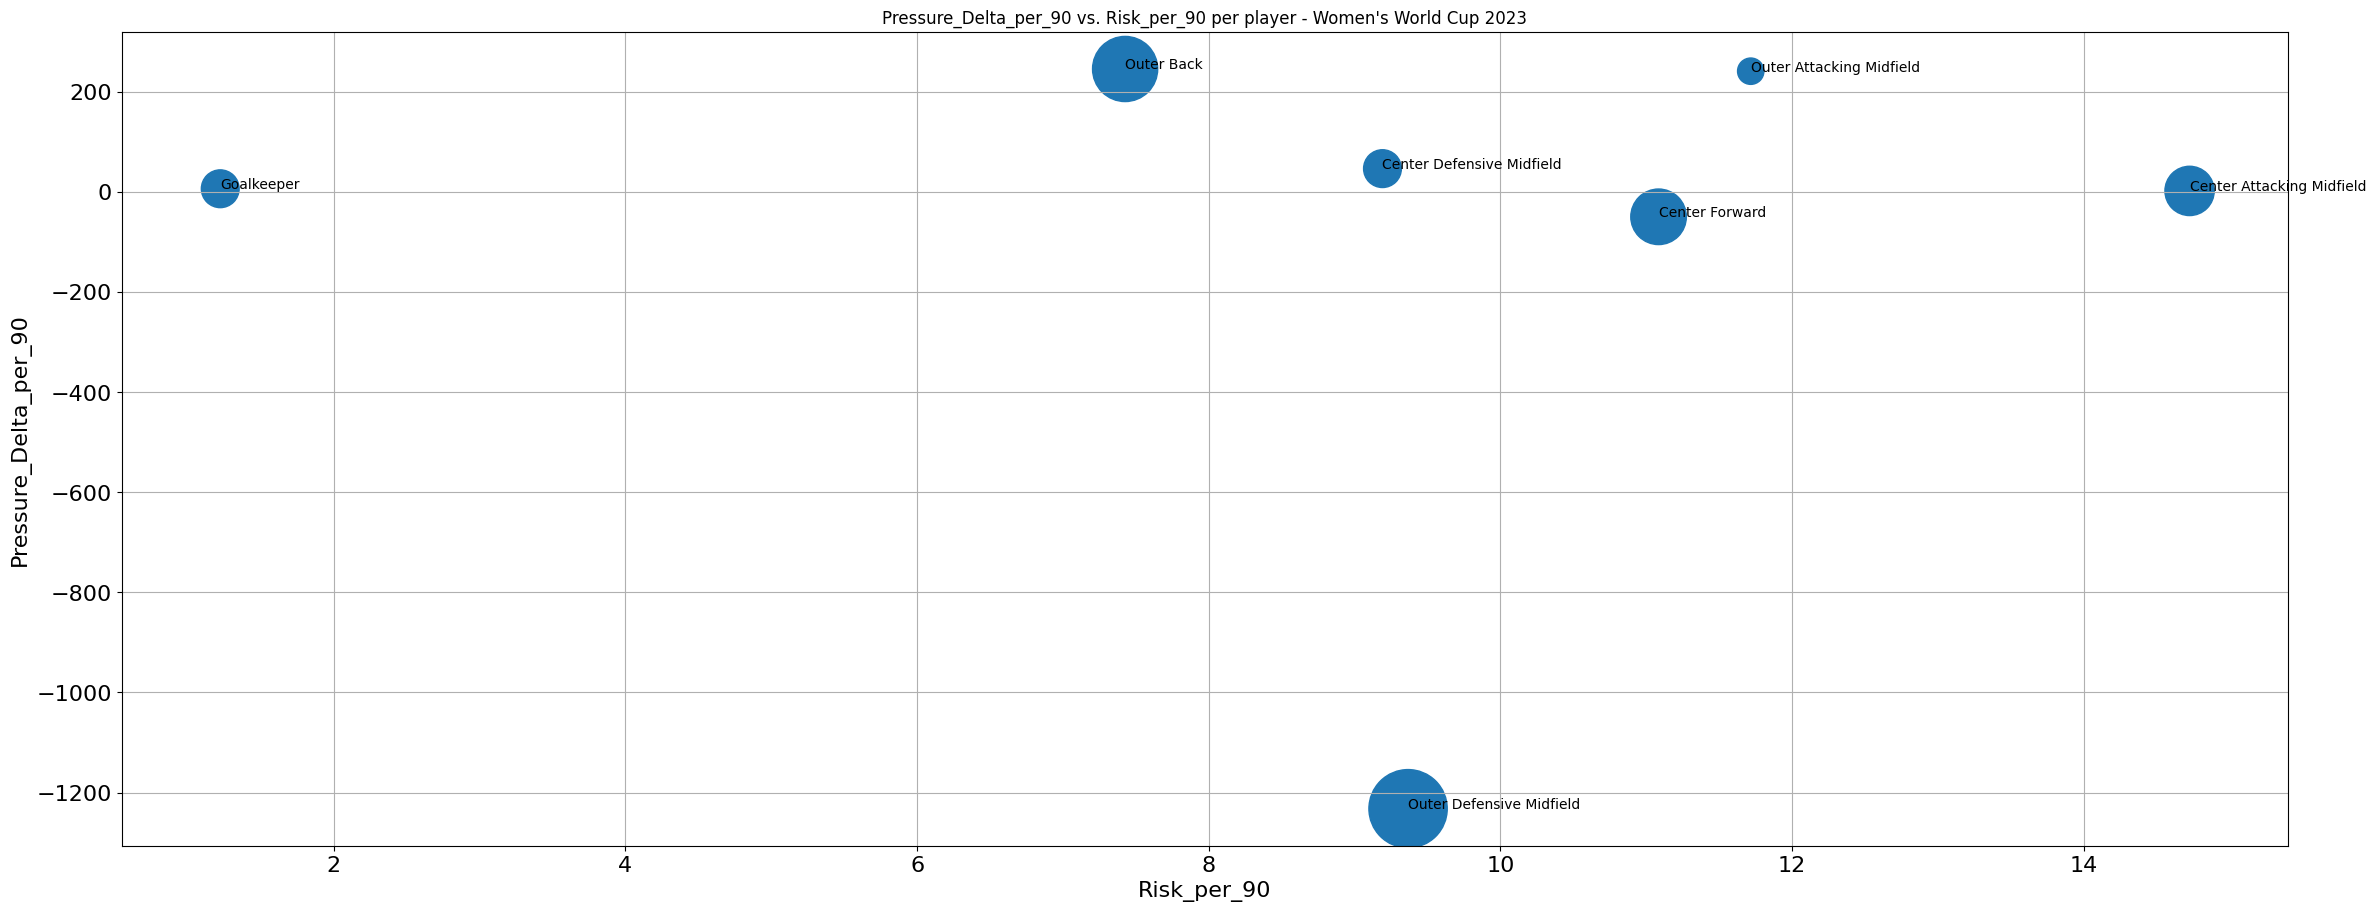

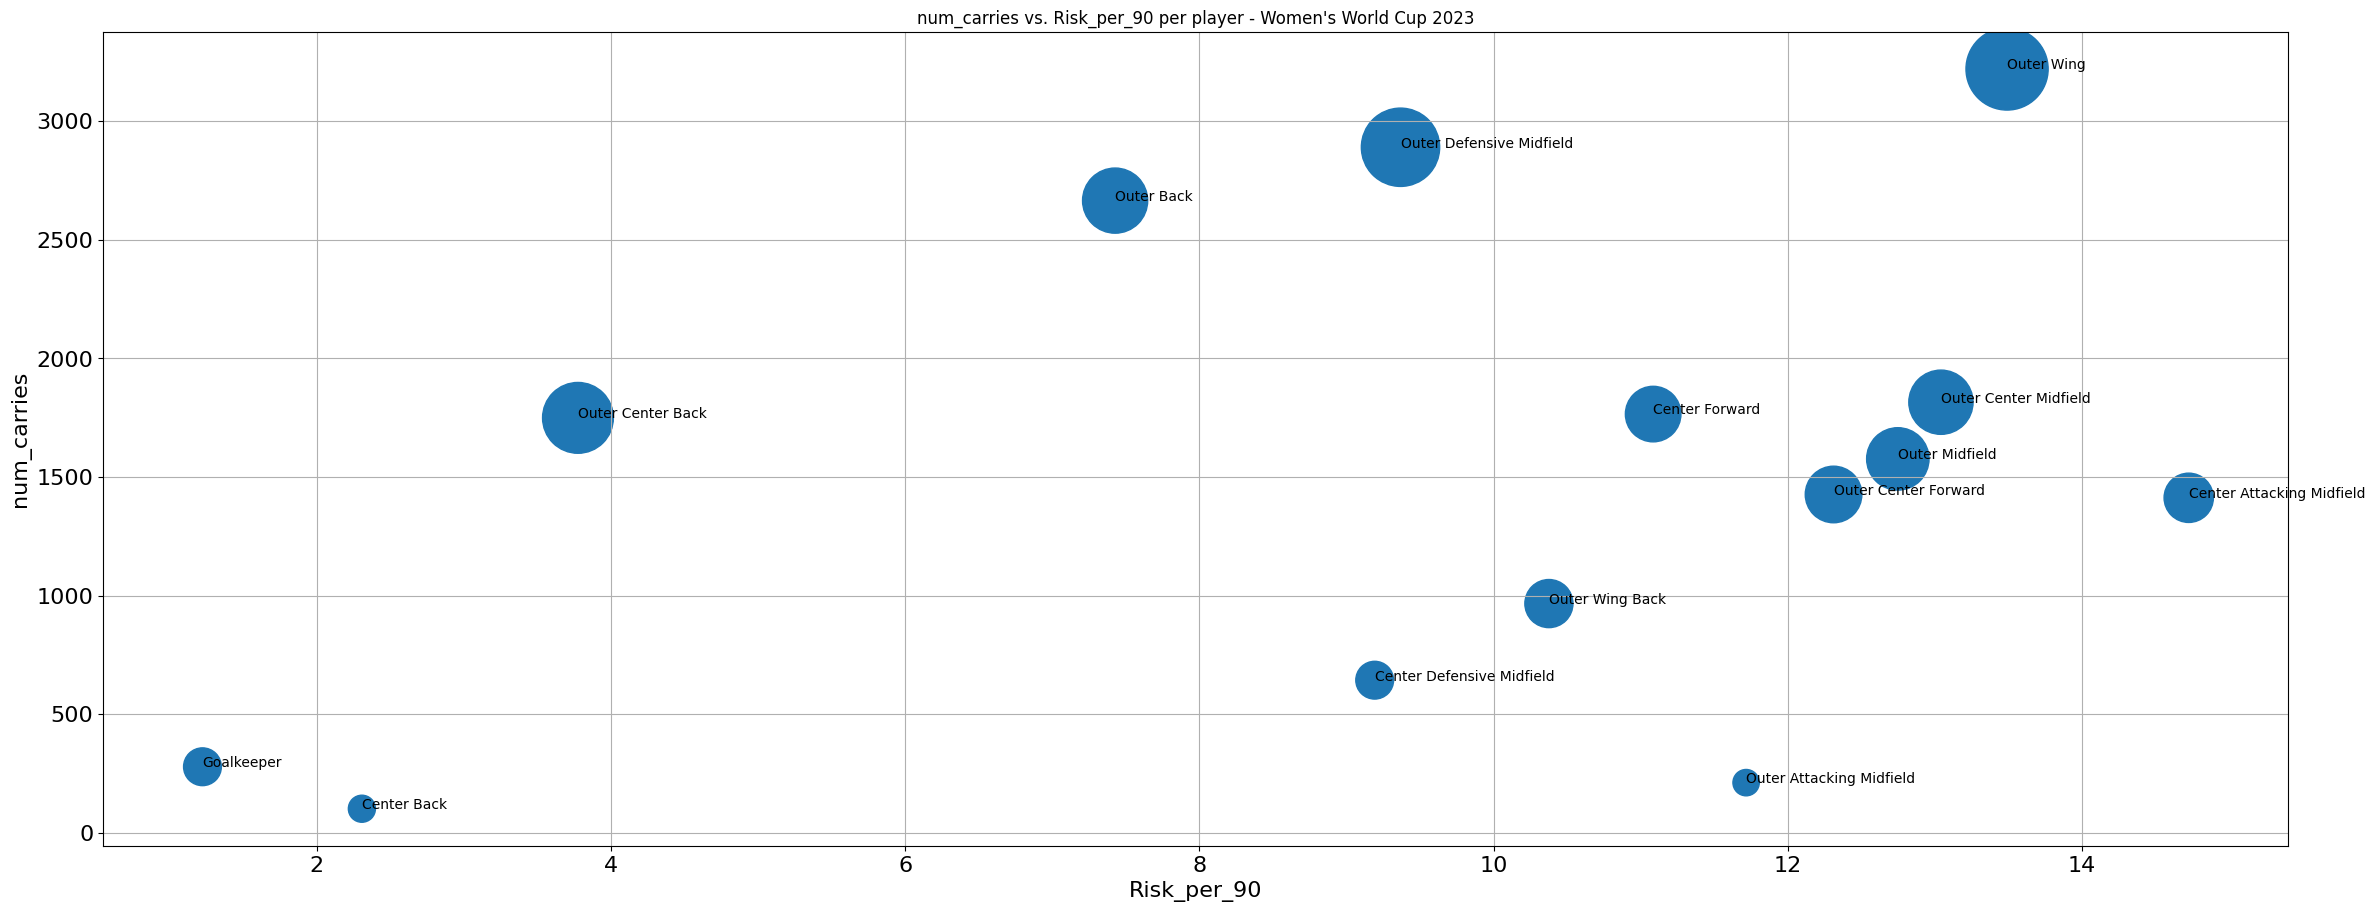

In [29]:
base = "Risk_per_90"


for target in ["vaep_value_per_90", "xT_gain_per_90", "advance_diff_per_90", "Pressure_Delta_per_90", "num_carries"]:
    scatterplot_with_groupby(positions, base, target, position_aggregation_column, size_col = "count")



In [30]:
total_vals.shape

(1179, 63)

In [31]:
total_vals.head(2)

,player_name,team_name,position_name,match_id,Unnamed: 0,period,minute,second,sub_type_name,x,...,Pressure_Delta_Norm_per_90,vaep_norm_per_90,xt_norm_per_90,Advance_Metric_Norm_per_90,Pressure_Delta_per_90,advance_diff_per_90,xT_gain_per_90,vaep_value_per_90,Risk_per_90,Outcome_over_Risk_per_90
0,Abbie Larkin,Republic of Ireland Women's,Left Wing,3893788,4876,8,298,177,0,319.3,...,7.113890,8.693692,10.142902,7.073819,2.839558,88.844909,0.058405,-0.059191,9.277932,9.277932
1,Abbie Larkin,Republic of Ireland Women's,Right Wing,11681419,76464,10,366,162,0,279.8,...,3.984096,5.316681,6.174085,4.487824,-5.411520,74.065626,0.051170,0.027195,5.851192,5.851192


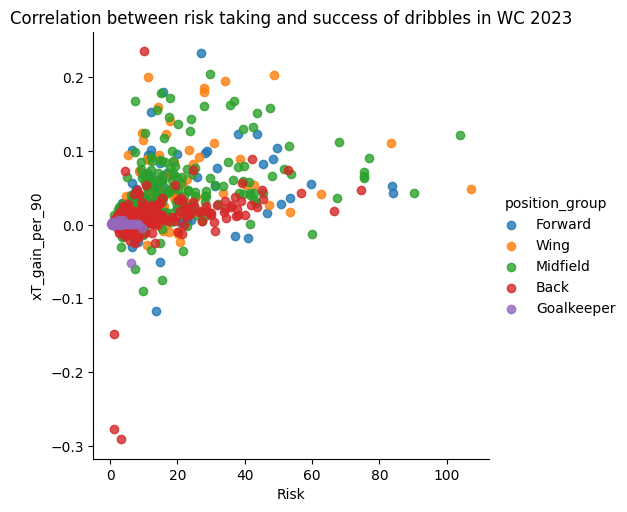

In [50]:
color_column = "position_group"
player_vals_with_minimum_60_min = total_vals[total_vals["playing_time_in_minutes"]>=60]
sns.lmplot(x = base, y = "xT_gain_per_90", data=player_vals_with_minimum_60_min, hue=color_column, fit_reg=False)
plt.title("Correlation between risk taking and success of dribbles in WC 2023")
plt.savefig('Grafiken/risk_taking_and_success_of_dribbles.png',bbox_inches='tight')
plt.show()

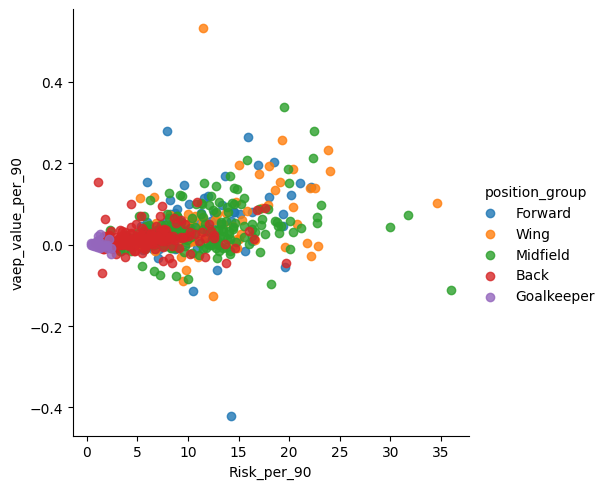

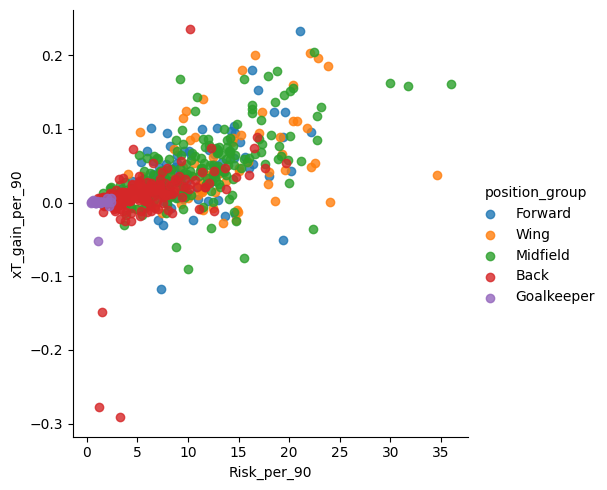

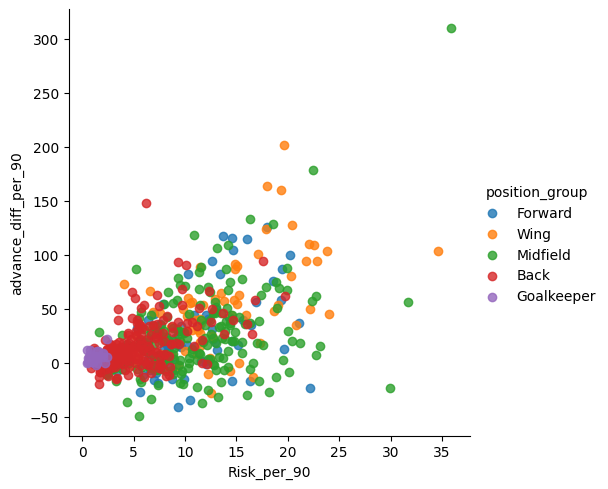

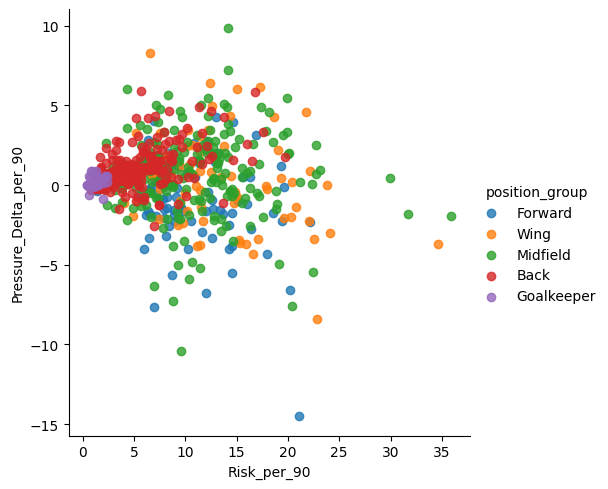

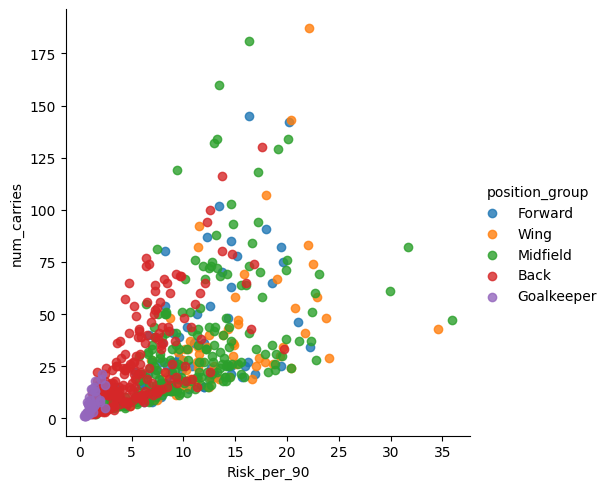

In [33]:
color_column = "position_group"
player_vals_with_minimum_60_min = total_vals[total_vals["playing_time_in_minutes"]>=60]
for target in ["vaep_value_per_90", "xT_gain_per_90", "advance_diff_per_90", "Pressure_Delta_per_90", "num_carries"]:
    
    sns.lmplot(x = base, y = target, data=player_vals_with_minimum_60_min, hue=color_column, fit_reg=False)

    plt.show()


In [34]:
player_vals_with_minimum_60_min.shape

(597, 63)

<Axes: >

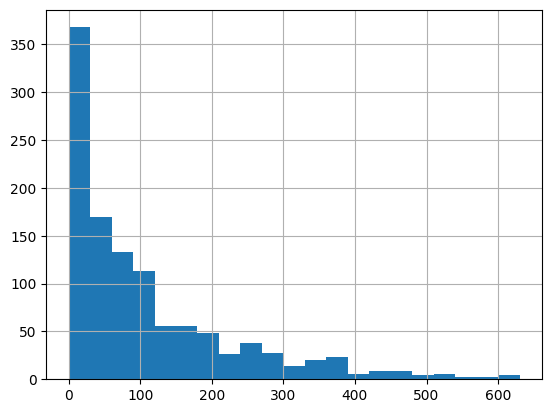

In [35]:
total_vals["playing_time_in_minutes"].hist(bins =  range(0, 660, 30))

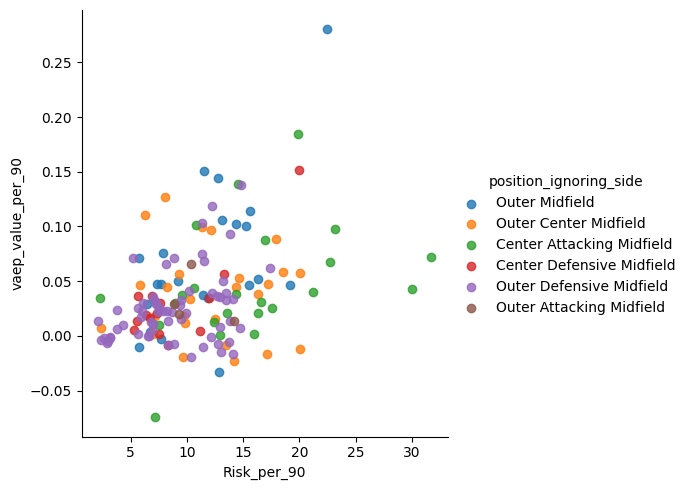

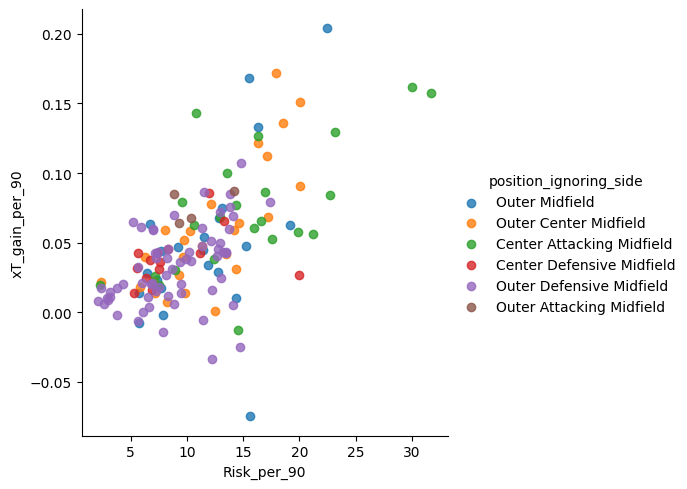

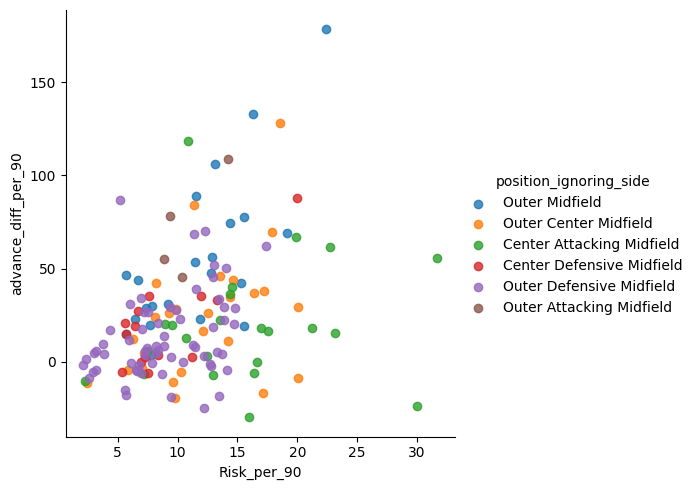

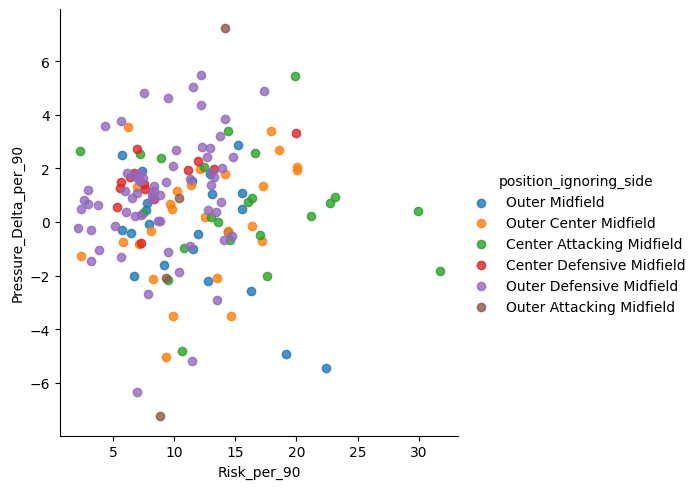

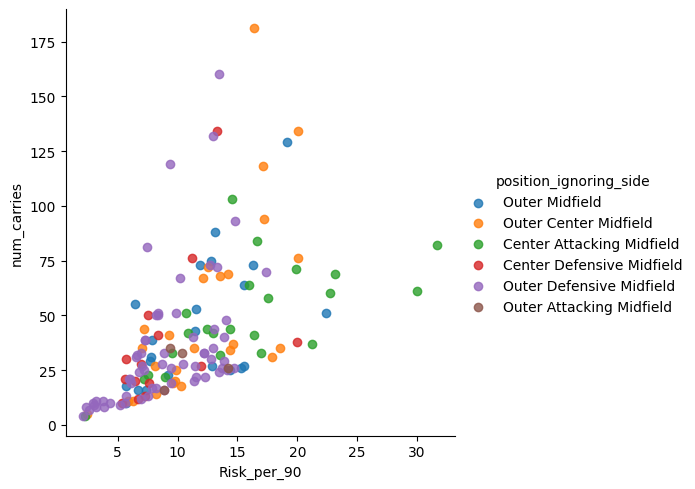

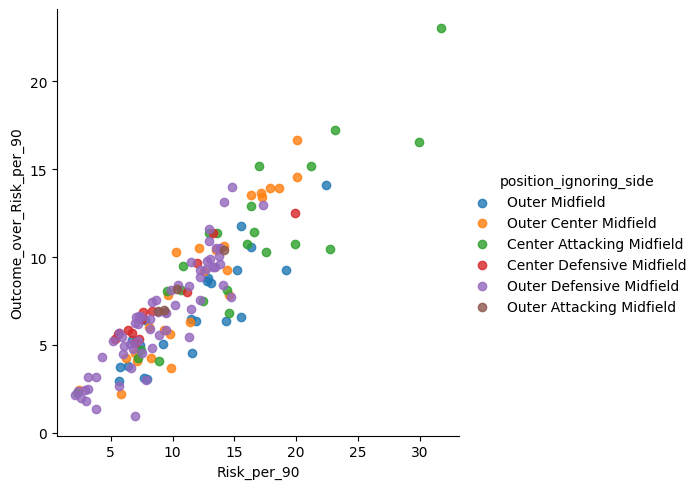

In [36]:
color_column = position_aggregation_column
midfield_position_values = total_vals[total_vals["position_group"]=="Midfield"]
midfield_position_values["position_ignoring_side"] = midfield_position_values["position_name"].str.replace("Right", "Outer").str.replace("Left", "Outer")
player_vals_with_minimum_60_min = midfield_position_values[midfield_position_values["playing_time_in_minutes"]>=90]
for target in ["vaep_value_per_90", "xT_gain_per_90", "advance_diff_per_90", "Pressure_Delta_per_90", "num_carries", 
              "Outcome_over_Risk_per_90"]:
    
    sns.lmplot(x = base, y = target, data=player_vals_with_minimum_60_min, hue=color_column, fit_reg=False)

    plt.show()


### Players <a class='anchor' id='results2'></a>
Analyzing risk and value of carries per player.

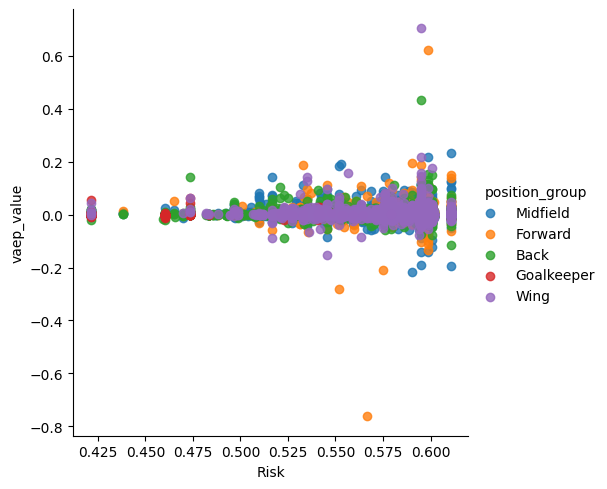

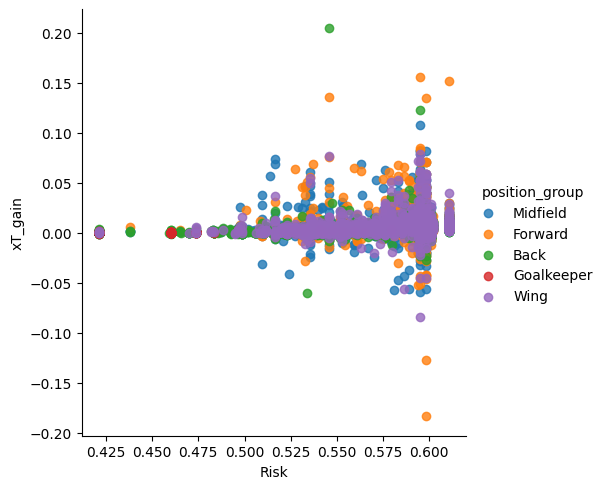

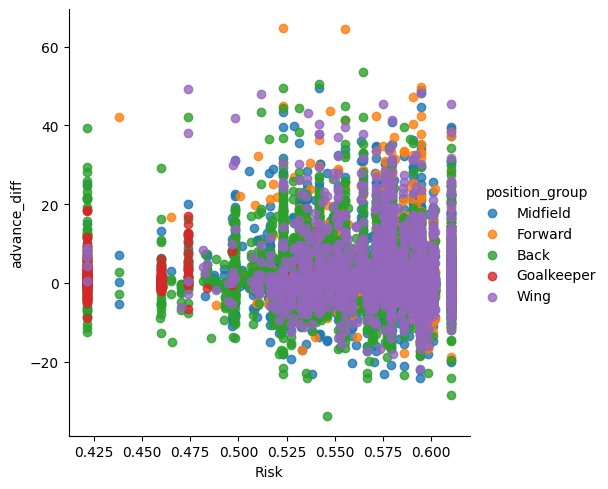

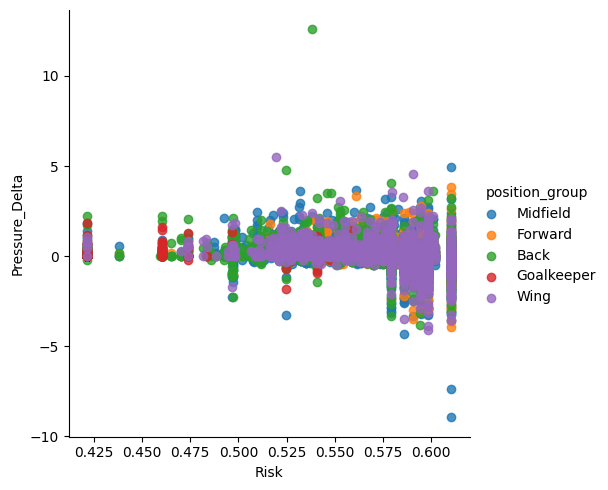

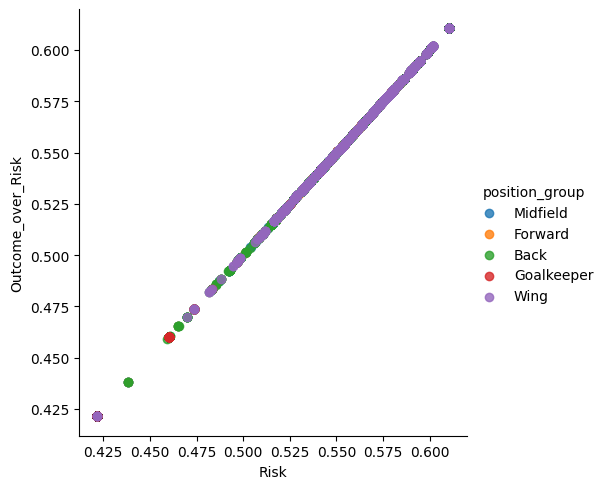

In [37]:
color_column = "position_group"
base = "Risk"
for target in ["vaep_value", "xT_gain", "advance_diff", "Pressure_Delta", "Outcome_over_Risk"]:
    
    sns.lmplot(x = base, y = target, data=carries[carries["Outcome"]==1], hue=color_column, fit_reg=False)

    plt.show()


# Evaluation of top players

In [38]:
player_teams = carries[["player_name", "team_name"]].drop_duplicates()

In [39]:
total_vals.sort_values("playing_time_in_minutes", ascending=False).to_excel("all_players_all_values.xlsx")

In [40]:
player_vals_with_minimum_60_min.sort_values("playing_time_in_minutes", ascending=False).to_excel("players_with_min_60_min_all_values.xlsx")

In [41]:
relevant_columns = ["player_name", "team_name", "position_name", "playing_time_in_minutes"] + [col for col in player_vals_with_minimum_60_min if "per_90" in col and "Norm" not in col]

In [42]:
final_df = player_vals_with_minimum_60_min[relevant_columns]

In [43]:
with pd.ExcelWriter('final_evaluation.xlsx') as writer:  
    final_df.to_excel(writer, sheet_name="all_players", index=False)
    final_df.sort_values("xT_gain_per_90", ascending=False).head(20).to_excel(writer, sheet_name = "Groeßter XT_Gewinn", index=False)
    final_df.sort_values("Outcome_over_Risk_per_90", ascending=False).head(20).to_excel(writer, sheet_name = "Erfolgsrate im Vgl. Risiko", index=False)
    final_df.sort_values("advance_diff_per_90", ascending=False).head(20).to_excel(writer, sheet_name = "Groeßte Gesamtdistanz", index=False)
    final_df.sort_values("Risk_per_90", ascending=False).head(20).to_excel(writer, sheet_name = "Groeßtes Gesamtrisiko", index=False)
    final_df.sort_values("Pressure_Delta_per_90", ascending=False).head(20).to_excel(writer, sheet_name = "Beste Druckloeser", index=False)

In [44]:
final_df

,player_name,team_name,position_name,playing_time_in_minutes,vaep_norm_per_90,xt_norm_per_90,Pressure_Delta_per_90,advance_diff_per_90,xT_gain_per_90,vaep_value_per_90,Risk_per_90,Outcome_over_Risk_per_90
8,Adriana Leal da Silva,Brazil Women's,Left Midfield,213.766667,14.043579,16.372728,1.097306,77.592108,0.168168,0.046909,15.539800,11.750622
15,Aitana Bonmati Conca,Spain Women's,Right Center Midfield,571.900000,14.837861,17.231642,-0.151428,36.678667,0.121720,0.038319,16.352338,13.519675
34,Alexandra Popp,Germany Women's,Center Attacking Midfield,130.483333,7.911369,9.132787,2.383403,20.578539,0.030161,0.030319,8.928026,4.099823
39,Alexia Putellas Segura,Spain Women's,Left Center Midfield,196.483333,18.141792,21.063008,1.932942,29.214842,0.151062,0.057819,20.047912,14.551263
70,Andi Sullivan,United States Women's,Center Defensive Midfield,267.466667,5.274028,6.106004,1.493005,14.770577,0.042488,0.036293,5.665579,5.665579
...,...,...,...,...,...,...,...,...,...,...,...,...
1140,Vilde Bøe Risa,Norway Women's,Right Center Midfield,100.216667,8.859790,10.277432,0.679830,-10.759385,0.039759,-0.019062,9.618542,7.822434
1144,Vyan Sampson,Jamaica Women's,Center Defensive Midfield,90.000000,6.251278,7.240609,1.840019,27.465603,0.037356,0.016507,6.691498,5.691498
1145,Vyan Sampson,Jamaica Women's,Left Defensive Midfield,168.066667,2.224896,2.590265,0.486840,1.348335,0.017285,-0.004099,2.354670,2.354670
1156,Xin Zhang,China PR Women's,Right Midfield,90.000000,14.117643,16.075991,0.496557,19.191376,-0.074655,0.113745,15.573489,6.573489
